In [1]:
import os
import sys

import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import clouddrift as cd
import cmocean.cm as cmo
import copernicusmarine as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyinterp
from tqdm import tqdm
import scipy as sp
from statsmodels.formula.api import logit
import xarray as xr
import xbatcher

/home/bertrava/.conda/envs/cyclogeostrophy_impact_experiment/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
sys.path.append("../experiment")

from preproc import apply_drifter_preproc
from preproc.drifter import DEFAULT_STEPS

In [29]:
CM_TO_IN = 1 / 2.54
MAX_WIDTH = 17.5 * CM_TO_IN
MAX_HEIGHT = 20.5 * CM_TO_IN
DPI = 300

FONT_SIZE = 8

plt.rc("font", size=FONT_SIZE)
plt.rc("axes", titlesize=FONT_SIZE)
plt.rc("axes", labelsize=FONT_SIZE)
plt.rc("xtick", labelsize=FONT_SIZE)
plt.rc("ytick", labelsize=FONT_SIZE)
plt.rc("legend", fontsize=FONT_SIZE)

HW_SPACE = .33 * CM_TO_IN


def get_gridspec_kwargs(fig_width: float, fig_height: float) -> dict:
    return dict(wspace=HW_SPACE / fig_width, hspace=HW_SPACE / fig_height)


CLB_AXIS_HW = 1.25 * CM_TO_IN
CLB_BAR_HW = .33 * CM_TO_IN
CLB_HW_SPACE = .33 * CM_TO_IN


def get_clb_kwargs(axes_width: float, axes_height: float, clb_location: str, clb_shrink: float) -> dict:
    if clb_location in ("bottom", "top"):
        axes_hw_fraction = axes_height
        axes_hw_aspect = axes_width
    else:
        axes_hw_fraction = axes_width
        axes_hw_aspect = axes_height
    
    fraction = CLB_AXIS_HW / axes_hw_fraction
    aspect = clb_shrink * axes_hw_aspect / CLB_BAR_HW
    pad = CLB_HW_SPACE / axes_hw_fraction

    return dict(location=clb_location, fraction=fraction, shrink=clb_shrink, aspect=aspect, pad=pad)


TITLE_H = .5 * CM_TO_IN

PLOT_NEUROST_GLOBAL_HW_RATIO = 206 / 496

In [3]:
CYCLO_PAPER_DIRPATH = "/summer/meom/workdir/bertrava/cyclogeostrophy-paper"
FIGURES_PATH = f"{CYCLO_PAPER_DIRPATH}/figures"

In [4]:
DRIFTER_RAW_PATH = f"{CYCLO_PAPER_DIRPATH}/gdp6h.zarr"
DRIFTER_FILT_PATH = f"{CYCLO_PAPER_DIRPATH}/gdp6h_filt.zarr"
FROM_YEAR = 2010
TO_YEAR = 2023

In [ ]:
def restrict_timeperiod(ds):
    ds.time.load()
    ds = cd.ragged.subset(
        ds, 
        {"time": lambda t: (t >= np.datetime64(str(FROM_YEAR))) & (t < np.datetime64(str(TO_YEAR)))}, 
        row_dim_name="traj"
    )
    return ds


def open_gdh6h():
    ds = xr.open_zarr(DRIFTER_RAW_PATH)
    ds = restrict_timeperiod(ds)
    ds = apply_drifter_preproc(ds, DEFAULT_STEPS)
    return ds

In [ ]:
gdp6h_ds = open_gdh6h()

# Filtering drifter velocities

We follow the same procedure as Muller et al. 2019:

1. Remove Ekman
2. Low-pass filter using a 2nd order Butterworth with a 25h cutoff

## Removing Ekman

We remove the Ekman contribution to the drifter velocities using GLOBCURRENT (https://doi.org/10.48670/mds-00327) Ekman currents (estimated following Rio et al. 2014).

In [ ]:
GLOBCURRENT_DIRPATH = "/summer/meom/workdir/bertrava"
GLOBCURRENT_FILENAME = "cmems_obs-mob_glo_phy-cur_my_0.25deg_PT1H-i.zarr"
GLOBCURRENT_PATH = f"{GLOBCURRENT_DIRPATH}/{GLOBCURRENT_FILENAME}"

In [ ]:
if not os.path.exists(GLOBCURRENT_PATH):
    globcurrent_ds = cm.subset(
        dataset_id="cmems_obs-mob_glo_phy-cur_my_0.25deg_PT1H-i",
        start_datetime=f"{FROM_YEAR}-01-01",
        end_datetime=f"{TO_YEAR}-01-01",
        variables=["ue", "ve"],
        minimum_depth=15,
        output_directory=CYCLO_PAPER_DIRPATH,
        output_filename=GLOBCURRENT_FILENAME,
    )

In [ ]:
globcurrent_ds = xr.open_zarr(GLOBCURRENT_PATH).isel(depth=0).drop_vars("depth")

In [ ]:
bgen = xbatcher.BatchGenerator(
    globcurrent_ds, 
    input_dims={"time": 60, "latitude": len(globcurrent_ds.latitude), "longitude": len(globcurrent_ds.longitude)}, 
    input_overlap={"time": 1}
)

In [ ]:
ekman_ve = np.empty_like(gdp6h_ds.ve) * np.nan
ekman_vn = np.empty_like(gdp6h_ds.vn) * np.nan

for ds in tqdm(bgen):
    x_axis = pyinterp.Axis(ds.longitude.values + 180, is_circle=True)
    y_axis = pyinterp.Axis(ds.latitude.values)
    t_axis = pyinterp.TemporalAxis(ds.time.values)

    u_grid = pyinterp.Grid3D(x_axis, y_axis, t_axis, ds.ue.values.transpose(2, 1, 0))
    v_grid = pyinterp.Grid3D(x_axis, y_axis, t_axis, ds.ve.values.transpose(2, 1, 0))

    mask = (gdp6h_ds.time >= ds.time.values[0]) & (gdp6h_ds.time < ds.time.values[-1])
    lon = gdp6h_ds.lon[mask] + 180
    lat = gdp6h_ds.lat[mask]
    time = gdp6h_ds.time[mask]

    ekman_ve[mask] = pyinterp.trivariate(u_grid, lon, lat, time)
    ekman_vn[mask] = pyinterp.trivariate(v_grid, lon, lat, time)

In [ ]:
ekman_ve[np.isnan(ekman_ve)] = 0
ekman_vn[np.isnan(ekman_vn)] = 0

In [ ]:
gdp6h_ds["ve_ekman"] = (("obs"), ekman_ve)
gdp6h_ds["vn_ekman"] = (("obs"), ekman_vn)

gdp6h_ds["ve_no_ekman"] = gdp6h_ds.ve - gdp6h_ds.ve_ekman
gdp6h_ds["vn_no_ekman"] = gdp6h_ds.vn - gdp6h_ds.vn_ekman

## Low-pass filtering

We use a 2nd order low-pass Butterworth filter with a cutoff period of 25 hours on the drifters velocities to remove unbalanced signals.

In [ ]:
def get_butter_lowpass(dt=6, cutoff=25, order=2):
    # hours to seconds
    dt *= 3600
    cutoff *= 3600

    nyq = 0.5 * 1 / dt
    normal_cutoff = 1 / (nyq * cutoff)

    b, a = sp.signal.butter(order, normal_cutoff, btype="low", analog=False)
    return b, a


def apply_butter_lowpass(x, y, b, a):
    complex_positions = x + 1j * y
    filtered_complex_positions = sp.signal.filtfilt(b, a, complex_positions)

    filtered_x = np.real(filtered_complex_positions)
    filtered_y = np.imag(filtered_complex_positions)

    return filtered_x, filtered_y

In [ ]:
gdp6h_filt_ds = gdp6h_ds.copy()

In [ ]:
gdp6h_filt_ds["ve_ekman"] = xr.where(np.isfinite(gdp6h_filt_ds["ve_ekman"]), gdp6h_filt_ds["ve_ekman"], 0)
gdp6h_filt_ds["vn_ekman"] = xr.where(np.isfinite(gdp6h_filt_ds["vn_ekman"]), gdp6h_filt_ds["vn_ekman"], 0)

gdp6h_ds["ve_no_ekman"] = gdp6h_ds.ve - gdp6h_ds.ve_ekman
gdp6h_ds["vn_no_ekman"] = gdp6h_ds.vn - gdp6h_ds.vn_ekman

In [ ]:
b, a = get_butter_lowpass()

# ensure enough points for filtering
gdp6h_filt_ds = cd.ragged.subset(
    gdp6h_filt_ds, {"rowsize": lambda arr: arr > 3 * max(len(a), len(b))}, row_dim_name="traj"
)

filtered_ve, filtered_vn = cd.ragged.apply_ragged(
    apply_butter_lowpass, (gdp6h_filt_ds.ve_no_ekman, gdp6h_filt_ds.vn_no_ekman), 
    rowsize=gdp6h_filt_ds.rowsize, b=b, a=a
)

In [ ]:
gdp6h_filt_ds["ve_no_ekman_filt"] = (("obs"), filtered_ve)
gdp6h_filt_ds["vn_no_ekman_filt"] = (("obs"), filtered_vn)

In [ ]:
gdp6h_filt_ds.to_zarr(DRIFTER_FILT_PATH, zarr_format=2)

In [ ]:
i_traj = 0
traj_len = gdp6h_ds.rowsize[i_traj].item()

full_sig = gdp6h_ds.ve[:traj_len].values + 1j * gdp6h_ds.vn[:traj_len].values
raw_sig = gdp6h_ds.ve_no_ekman[:traj_len].values + 1j * gdp6h_ds.vn_no_ekman[:traj_len].values
filtered_sig = gdp6h_ds.ve_no_ekman_filt[:traj_len].values + 1j * gdp6h_ds.vn_no_ekman_filt[:traj_len].values

In [ ]:
nperseg = len(raw_sig) // 3
noverlap = nperseg // 4
fs = 1 / (6 * 3600) 

full_freq, full_psd = sp.signal.welch(full_sig, fs=fs, nperseg=nperseg, noverlap=noverlap)
raw_freq, raw_psd = sp.signal.welch(raw_sig, fs=fs, nperseg=nperseg, noverlap=noverlap)
filtered_freq, filtered_psd = sp.signal.welch(filtered_sig, fs=fs, nperseg=nperseg, noverlap=noverlap)

In [ ]:
fig, ax = plt.subplots()


ax.semilogy(full_freq, full_psd, label="Full")
ax.semilogy(raw_freq, raw_psd, label="No Ekman")
ax.semilogy(filtered_freq, filtered_psd, label="No Ekman filtered")

ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Power Spectral Density (m$^2$/s$^2$/Hz)")
ax.set_title("Drifter Velocity Power Spectral Density")

ax.set_xlim(-3e-5, 3e-5)
ax.set_ylim(0.01, 5e4)
ax.grid()
ax.legend()

fig.tight_layout()
plt.show()

# Evaluation

We compare geostrophic and cyclogeostrophic reconstructions to the filtered drifter velocities.

## Interpolating model velocities at drifter positions

In [5]:
NEUROST_VAR_PATH = f"{CYCLO_PAPER_DIRPATH}/neurost-global/2025-02-07/14-50-54/results/all_times_kinematics.zarr"
NEUROST_IT_PATH = f"{CYCLO_PAPER_DIRPATH}/neurost-global/2025-02-07/14-29-44/results/all_times_kinematics.zarr"
DUACS_VAR_PATH = f"{CYCLO_PAPER_DIRPATH}/duacs-global/2025-02-07/14-56-12/results/all_times_kinematics.zarr"
DUACS_IT_PATH = f"{CYCLO_PAPER_DIRPATH}/duacs-global/2025-02-09/10-55-14/results/all_times_kinematics.zarr"

In [ ]:
gdp6h_filt_ds = xr.open_zarr(DRIFTER_FILT_PATH)

In [ ]:
neurost_var_ds = xr.open_zarr(NEUROST_VAR_PATH)
neurost_it_ds = xr.open_zarr(NEUROST_IT_PATH)
duacs_var_ds = xr.open_zarr(DUACS_VAR_PATH)
duacs_it_ds = xr.open_zarr(DUACS_IT_PATH)

In [ ]:
neurost_ds = neurost_var_ds[["u_Geostrophy", "v_Geostrophy", "u_Cyclogeostrophy", "v_Cyclogeostrophy"]]
neurost_ds = neurost_ds.rename({
    "u_Geostrophy": "u_geos",
    "v_Geostrophy": "v_geos",
    "u_Cyclogeostrophy": "u_var",
    "v_Cyclogeostrophy": "v_var",
})
neurost_ds["u_it"] = neurost_it_ds.u_Cyclogeostrophy
neurost_ds["v_it"] = neurost_it_ds.v_Cyclogeostrophy

In [ ]:
duacs_ds = duacs_var_ds[["u_Geostrophy", "v_Geostrophy", "u_Cyclogeostrophy", "v_Cyclogeostrophy"]]
duacs_ds = duacs_ds.rename({
    "u_Geostrophy": "u_geos",
    "v_Geostrophy": "v_geos",
    "u_Cyclogeostrophy": "u_var",
    "v_Cyclogeostrophy": "v_var",
})
duacs_ds["u_it"] = duacs_it_ds.u_Cyclogeostrophy
duacs_ds["v_it"] = duacs_it_ds.v_Cyclogeostrophy

In [ ]:
neurost_bgen = xbatcher.BatchGenerator(
    neurost_ds, 
    input_dims={"time": 60, "latitude": len(neurost_ds.latitude), "longitude": len(neurost_ds.longitude)}, 
    input_overlap={"time": 1}
)

neurost_geos_ve = np.empty_like(gdp6h_ds.ve) * np.nan
neurost_geos_vn = np.empty_like(gdp6h_ds.vn) * np.nan
neurost_var_ve = np.empty_like(gdp6h_ds.ve) * np.nan
neurost_var_vn = np.empty_like(gdp6h_ds.vn) * np.nan
neurost_it_ve = np.empty_like(gdp6h_ds.ve) * np.nan
neurost_it_vn = np.empty_like(gdp6h_ds.vn) * np.nan

for ds in tqdm(neurost_bgen):
    x_axis = pyinterp.Axis(ds.longitude.values + 180, is_circle=True)
    y_axis = pyinterp.Axis(ds.latitude.values)
    t_axis = pyinterp.TemporalAxis(ds.time.values)

    geos_ve_grid = pyinterp.Grid3D(x_axis, y_axis, t_axis, ds.u_geos.values.transpose(2, 1, 0))
    geos_vn_grid = pyinterp.Grid3D(x_axis, y_axis, t_axis, ds.v_geos.values.transpose(2, 1, 0))
    var_ve_grid = pyinterp.Grid3D(x_axis, y_axis, t_axis, ds.u_var.values.transpose(2, 1, 0))
    var_vn_grid = pyinterp.Grid3D(x_axis, y_axis, t_axis, ds.v_var.values.transpose(2, 1, 0))
    it_ve_grid = pyinterp.Grid3D(x_axis, y_axis, t_axis, ds.u_it.values.transpose(2, 1, 0))
    it_vn_grid = pyinterp.Grid3D(x_axis, y_axis, t_axis, ds.v_it.values.transpose(2, 1, 0))

    mask = (gdp6h_ds.time >= ds.time.values[0]) & (gdp6h_ds.time < ds.time.values[-1])
    lon = gdp6h_ds.lon[mask] + 180
    lat = gdp6h_ds.lat[mask]
    time = gdp6h_ds.time[mask]

    neurost_geos_ve[mask] = pyinterp.trivariate(geos_ve_grid, lon, lat, time)
    neurost_geos_vn[mask] = pyinterp.trivariate(geos_vn_grid, lon, lat, time)
    neurost_var_ve[mask] = pyinterp.trivariate(var_ve_grid, lon, lat, time)
    neurost_var_vn[mask] = pyinterp.trivariate(var_vn_grid, lon, lat, time)
    neurost_it_ve[mask] = pyinterp.trivariate(it_ve_grid, lon, lat, time)
    neurost_it_vn[mask] = pyinterp.trivariate(it_vn_grid, lon, lat, time)

In [ ]:
gdp6h_filt_ds["ve_neurost_geos"] = (("obs"), neurost_geos_ve)
gdp6h_filt_ds["vn_neurost_geos"] = (("obs"), neurost_geos_vn)
gdp6h_filt_ds["ve_neurost_var"] = (("obs"), neurost_var_ve)
gdp6h_filt_ds["vn_neurost_var"] = (("obs"), neurost_var_vn)
gdp6h_filt_ds["ve_neurost_it"] = (("obs"), neurost_it_ve)
gdp6h_filt_ds["vn_neurost_it"] = (("obs"), neurost_it_vn)

In [ ]:
gdp6h_filt_ds.to_zarr(DRIFTER_FILT_PATH, mode="a")

In [ ]:
duacs_bgen = xbatcher.BatchGenerator(
    duacs_ds, 
    input_dims={"time": 60, "latitude": len(duacs_ds.latitude), "longitude": len(duacs_ds.longitude)}, 
    input_overlap={"time": 1}
)

duacs_geos_ve = np.empty_like(gdp6h_ds.ve) * np.nan
duacs_geos_vn = np.empty_like(gdp6h_ds.vn) * np.nan
duacs_var_ve = np.empty_like(gdp6h_ds.ve) * np.nan
duacs_var_vn = np.empty_like(gdp6h_ds.vn) * np.nan
duacs_it_ve = np.empty_like(gdp6h_ds.ve) * np.nan
duacs_it_vn = np.empty_like(gdp6h_ds.vn) * np.nan

for ds in tqdm(duacs_bgen):
    x_axis = pyinterp.Axis(ds.longitude.values + 180, is_circle=True)
    y_axis = pyinterp.Axis(ds.latitude.values)
    t_axis = pyinterp.TemporalAxis(ds.time.values)

    geos_ve_grid = pyinterp.Grid3D(x_axis, y_axis, t_axis, ds.u_geos.values.transpose(2, 1, 0))
    geos_vn_grid = pyinterp.Grid3D(x_axis, y_axis, t_axis, ds.v_geos.values.transpose(2, 1, 0))
    var_ve_grid = pyinterp.Grid3D(x_axis, y_axis, t_axis, ds.u_var.values.transpose(2, 1, 0))
    var_vn_grid = pyinterp.Grid3D(x_axis, y_axis, t_axis, ds.v_var.values.transpose(2, 1, 0))
    it_ve_grid = pyinterp.Grid3D(x_axis, y_axis, t_axis, ds.u_it.values.transpose(2, 1, 0))
    it_vn_grid = pyinterp.Grid3D(x_axis, y_axis, t_axis, ds.v_it.values.transpose(2, 1, 0))

    mask = (gdp6h_ds.time >= ds.time.values[0]) & (gdp6h_ds.time < ds.time.values[-1])
    lon = gdp6h_ds.lon[mask] + 180
    lat = gdp6h_ds.lat[mask]
    time = gdp6h_ds.time[mask]

    duacs_geos_ve[mask] = pyinterp.trivariate(geos_ve_grid, lon, lat, time)
    duacs_geos_vn[mask] = pyinterp.trivariate(geos_vn_grid, lon, lat, time)
    duacs_var_ve[mask] = pyinterp.trivariate(var_ve_grid, lon, lat, time)
    duacs_var_vn[mask] = pyinterp.trivariate(var_vn_grid, lon, lat, time)
    duacs_it_ve[mask] = pyinterp.trivariate(it_ve_grid, lon, lat, time)
    duacs_it_vn[mask] = pyinterp.trivariate(it_vn_grid, lon, lat, time)

In [ ]:
gdp6h_filt_ds["ve_duacs_geos"] = (("obs"), duacs_geos_ve)
gdp6h_filt_ds["vn_duacs_geos"] = (("obs"), duacs_geos_vn)
gdp6h_filt_ds["ve_duacs_var"] = (("obs"), duacs_var_ve)
gdp6h_filt_ds["vn_duacs_var"] = (("obs"), duacs_var_vn)
gdp6h_filt_ds["ve_duacs_it"] = (("obs"), duacs_it_ve)
gdp6h_filt_ds["vn_duacs_it"] = (("obs"), duacs_it_vn)

In [ ]:
gdp6h_filt_ds.to_zarr(DRIFTER_FILT_PATH, mode="a")

## Evaluating reconstructions against drifters

In [6]:
gdp6h_filt_ds = xr.open_zarr(f"{DRIFTER_FILT_PATH}")

### Spatially binned RMSE calculation

In [7]:
RMSE_PATH = f"{CYCLO_PAPER_DIRPATH}/rmse.zarr"

In [8]:
BIN_SIZE = 1  # in °
MIN_OBS = 200

In [9]:
def attach_residuals(drifter_ds, product, reconstruction_method):
    drifter_ds[f"res_{product}_{reconstruction_method}"] = (
        (
            (drifter_ds[f"ve_{product}_{reconstruction_method}"] - drifter_ds["ve_no_ekman_filt"]) ** 2 + 
            (drifter_ds[f"vn_{product}_{reconstruction_method}"] - drifter_ds["vn_no_ekman_filt"]) ** 2
        )
    )
    return drifter_ds


def get_spatial_binned_errors(drifter_ds):
    latitude = np.arange(-90, 90, BIN_SIZE) + (BIN_SIZE / 2)
    longitude = np.arange(-180, 180, BIN_SIZE) + (BIN_SIZE / 2)

    binning = pyinterp.Binning2D(pyinterp.Axis(longitude + 180, is_circle=True), pyinterp.Axis(latitude))
    data_vars = {}

    binning.push(drifter_ds.lon + 180, drifter_ds.lat, drifter_ds.res_neurost_geos, False)
    data_vars["rmse_neurost_geos"] = (["latitude", "longitude"], np.sqrt(binning.variable("mean")).T, {"units": "$m/s$"})

    binning.clear()
    binning.push(drifter_ds.lon + 180, drifter_ds.lat, drifter_ds.res_neurost_var, False)
    data_vars["rmse_neurost_var"] = (["latitude", "longitude"], np.sqrt(binning.variable("mean")).T, {"units": "$m/s$"})

    binning.clear()
    binning.push(drifter_ds.lon + 180, drifter_ds.lat, drifter_ds.res_neurost_it, False)
    data_vars["rmse_neurost_it"] = (["latitude", "longitude"], np.sqrt(binning.variable("mean")).T, {"units": "$m/s$"})

    binning.clear()
    binning.push(drifter_ds.lon + 180, drifter_ds.lat, drifter_ds.res_duacs_geos, False)
    data_vars["rmse_duacs_geos"] = (["latitude", "longitude"], np.sqrt(binning.variable("mean")).T, {"units": "$m/s$"})

    binning.clear()
    binning.push(drifter_ds.lon + 180, drifter_ds.lat, drifter_ds.res_duacs_var, False)
    data_vars["rmse_duacs_var"] = (["latitude", "longitude"], np.sqrt(binning.variable("mean")).T, {"units": "$m/s$"})

    binning.clear()
    binning.push(drifter_ds.lon + 180, drifter_ds.lat, drifter_ds.res_duacs_it, False)
    data_vars["rmse_duacs_it"] = (["latitude", "longitude"], np.sqrt(binning.variable("mean")).T, {"units": "$m/s$"})

    data_vars["count"] = (["latitude", "longitude"], binning.variable("count").T)
    
    coords = {
        "latitude": (["latitude"], latitude),
        "longitude": (["longitude"], longitude)
    }
    ds = xr.Dataset(data_vars=data_vars, coords=coords)

    ds = ds.where(np.abs(ds.latitude) > 5)  # discard equatorial bins
    ds = ds.where(ds["count"] >= MIN_OBS)  # discard bins with "too few" observations

    return ds

In [10]:
gdp6h_filt_ds = attach_residuals(gdp6h_filt_ds, "neurost", "geos")
gdp6h_filt_ds = attach_residuals(gdp6h_filt_ds, "neurost", "var")
gdp6h_filt_ds = attach_residuals(gdp6h_filt_ds, "neurost", "it")
gdp6h_filt_ds = attach_residuals(gdp6h_filt_ds, "duacs", "geos")
gdp6h_filt_ds = attach_residuals(gdp6h_filt_ds, "duacs", "var")
gdp6h_filt_ds = attach_residuals(gdp6h_filt_ds, "duacs", "it")

In [11]:
gdp6h_filt_ds = gdp6h_filt_ds.where(
    (
        np.isfinite(gdp6h_filt_ds.res_neurost_geos).compute() &
        np.isfinite(gdp6h_filt_ds.res_neurost_var).compute() &
        np.isfinite(gdp6h_filt_ds.res_neurost_it).compute() &
        np.isfinite(gdp6h_filt_ds.res_duacs_geos).compute() &
        np.isfinite(gdp6h_filt_ds.res_duacs_var).compute() &
        np.isfinite(gdp6h_filt_ds.res_duacs_it).compute()
    ), 
    drop=True
)

In [ ]:
rmse_ds = get_spatial_binned_errors(gdp6h_filt_ds)

In [ ]:
rmse_ds["delta_rmse_neurost_geos_var"] = \
    (rmse_ds["rmse_neurost_geos"] - rmse_ds["rmse_neurost_var"]) / rmse_ds["rmse_neurost_geos"] * 100

rmse_ds["delta_rmse_duacs_geos_var"] = \
    (rmse_ds["rmse_duacs_geos"] - rmse_ds["rmse_duacs_var"]) / rmse_ds["rmse_duacs_geos"] * 100

rmse_ds["delta_rmse_duacs_geos_neurost_var"] = \
    (rmse_ds["rmse_duacs_geos"] - rmse_ds["rmse_neurost_var"]) / rmse_ds["rmse_duacs_geos"] * 100

In [ ]:
rmse_ds.to_zarr(RMSE_PATH, zarr_format=2)

#### Plots

In [12]:
rmse_ds = xr.open_zarr(RMSE_PATH)

In [13]:
RMS_DIFF_REL_MAX = 20


def plot_diff(
    rmse_diff: xr.DataArray, latitude: xr.DataArray, longitude: xr.DataArray, title: str, label: str, ax: GeoAxes
):
    im = ax.pcolormesh(
        longitude, latitude, rmse_diff,
        cmap=cmo.balance_r, vmin=-RMS_DIFF_REL_MAX, vmax=RMS_DIFF_REL_MAX,
        transform=ccrs.PlateCarree()
    )
    ax.coastlines()

    ax.set_title(title, fontsize=FONT_SIZE)
    ax.set_title(label, loc="left", fontsize=FONT_SIZE)

    return im

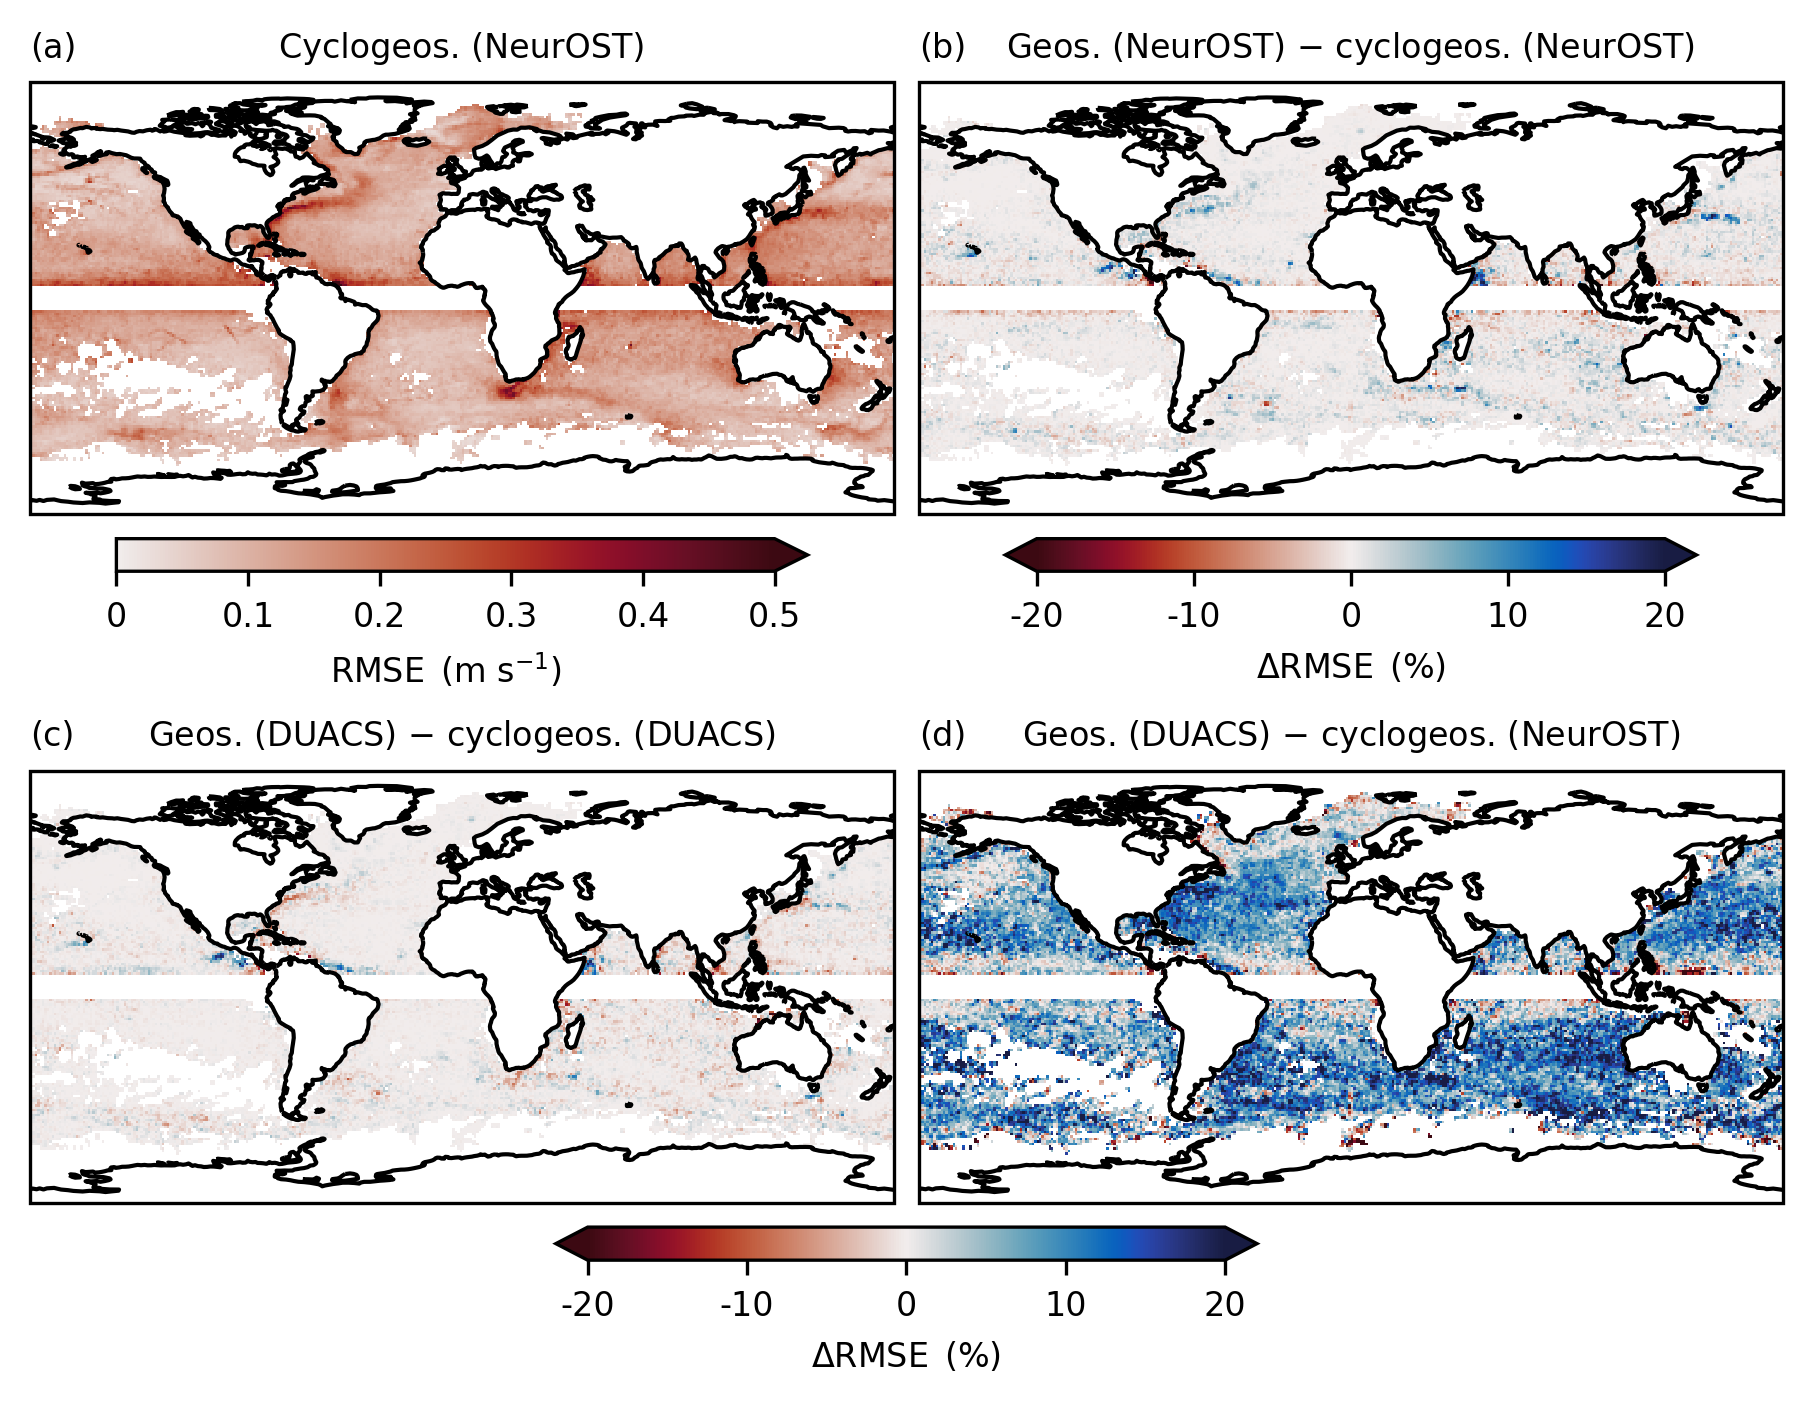

In [14]:
n_rows = 2
n_cols = 2
fig_width = MAX_WIDTH
fig_height = min(
    (
        ((fig_width - HW_SPACE * (n_cols - 1)) / n_cols * PLOT_NEUROST_GLOBAL_HW_RATIO + TITLE_H) * n_rows + 
        HW_SPACE * (n_rows - 1) + (CLB_AXIS_HW + CLB_HW_SPACE) * n_rows
    ),
    MAX_HEIGHT
)

fig, axd = plt.subplot_mosaic(
    """
    AB
    CD
    """,
    subplot_kw=dict(projection=ccrs.PlateCarree()),
    gridspec_kw=get_gridspec_kwargs(fig_width, fig_height),
    figsize=(fig_width, fig_height), dpi=DPI, layout="compressed"
)

im_a = axd["A"].pcolormesh(
    rmse_ds.longitude, rmse_ds.latitude, rmse_ds.rmse_neurost_var,
    cmap=cmo.amp, vmin=0, vmax=0.5,
    transform=ccrs.PlateCarree()
)
axd["A"].coastlines()
axd["A"].set_title("Cyclogeos. (NeurOST)", fontsize=FONT_SIZE)
axd["A"].set_title("(a)", loc="left", fontsize=FONT_SIZE)

clb_a = fig.colorbar(
    im_a, ax=axd["A"], 
    **get_clb_kwargs(fig_width / 2, fig_height / 2, clb_location="bottom", clb_shrink=.8),
    extend="max"
)
clb_a.set_label(label="$\\operatorname{RMSE}$ (m s$^{-1}$)", size=FONT_SIZE)
tick_labels = [0, .1, .2, .3, .4, .5]
clb_a.set_ticks(tick_labels)
clb_a.set_ticklabels(tick_labels, fontsize=FONT_SIZE)

im_b = plot_diff(
    rmse_ds.delta_rmse_neurost_geos_var, rmse_ds.latitude, rmse_ds.longitude,
    "Geos. (NeurOST) $-$ cyclogeos. (NeurOST)",
    "(b)",
    axd["B"]
)

clb_b = fig.colorbar(
    im_b, ax=axd["B"],
    **get_clb_kwargs(fig_width / 2, fig_height / 2, clb_location="bottom", clb_shrink=.8), 
    extend="both"
)
clb_b.set_label(label="$\Delta\\operatorname{RMSE}$ (%)", size=FONT_SIZE)
tick_labels = [-20, -10, 0, 10, 20]
clb_b.set_ticks(tick_labels)
clb_b.set_ticklabels(tick_labels, fontsize=FONT_SIZE)

_ = plot_diff(
    rmse_ds.delta_rmse_duacs_geos_var, rmse_ds.latitude, rmse_ds.longitude,
    "Geos. (DUACS) $-$ cyclogeos. (DUACS)",
    "(c)",
    axd["C"]
)

_ = plot_diff(
    rmse_ds.delta_rmse_duacs_geos_neurost_var, rmse_ds.latitude, rmse_ds.longitude,
    "Geos. (DUACS) $-$ cyclogeos. (NeurOST)",
    "(d)",
    axd["D"]
)

clb_cb = fig.colorbar(
    im_b, ax=list(axd.values())[2:],
    **get_clb_kwargs(fig_width, fig_height / 2, clb_location="bottom", clb_shrink=.4), 
    extend="both"
)
clb_cb.set_label(label="$\Delta\\operatorname{RMSE}$ (%)", size=FONT_SIZE)
tick_labels = [-20, -10, 0, 10, 20]
clb_cb.set_ticks(tick_labels)
clb_cb.set_ticklabels(tick_labels, fontsize=FONT_SIZE)

plt.savefig(
    f"{FIGURES_PATH}/f05-revised.png", dpi=DPI, bbox_inches="tight"
)

plt.show()

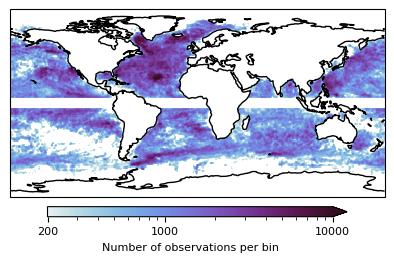

In [24]:
fig_width = MAX_WIDTH * .85
fig_height = min(fig_width * PLOT_NEUROST_GLOBAL_HW_RATIO + CLB_AXIS_HW + CLB_HW_SPACE, MAX_HEIGHT)

fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(fig_width, fig_height))

im = ax.pcolormesh(
    rmse_ds.longitude, rmse_ds.latitude, rmse_ds["count"],
    cmap=cmo.dense, norm=colors.LogNorm(vmin=200, vmax=1e4),
    transform=ccrs.PlateCarree()
)
ax.coastlines()

clb = fig.colorbar(
    im, ax=ax, 
    **get_clb_kwargs(fig_width, fig_height, clb_location="bottom", clb_shrink=.66),
    extend="max"
)
clb.set_label(label="Number of observations per bin", size=FONT_SIZE)
tick_labels = [200, 1000, 10000]
clb.set_ticks(tick_labels)
clb.set_ticklabels(tick_labels, fontsize=FONT_SIZE)

plt.savefig(f"{FIGURES_PATH}/fB01-revised.png", dpi=DPI, bbox_inches="tight")

plt.show()

### Probability of improving reconstruction when using cyclogeostrophy

We fit a logistic regression model to estimate the probability of improving the reconstruction when using cyclogeostrophy instead of geostrophy only, conditionned on the norm of the cyclostrophic velocity.

In [15]:
def do_logit_fit(X, Z, X_pred, spline_knots):
    df = pd.DataFrame({"X": X, "Z": Z})
    df_pred = pd.DataFrame({"X": X_pred})

    model_res = logit(f"Z ~ bs(X, df={spline_knots}, include_intercept=False)", data=df).fit(disp=False)
    Z_res = model_res.get_prediction(df_pred)

    return model_res, Z_res


def get_logit_fit(ds, x_label, z_label, spline_knots=4):
    X = ds[x_label].values
    Z = ds[z_label].values

    mask = ~np.isnan(X) & ~np.isnan(Z)
    X = X[mask]
    Z = Z[mask]

    bins = np.linspace(0, 0.5, 100)
    bin_idx = np.digitize(X, bins)

    bin_mean_X = []
    bin_mean_Z = []
    bin_counts = []
    for i in range(1, len(bins)):
        mask = (bin_idx == i)
        n_bins = np.sum(mask)
        bin_mean_X.append(X[bin_idx == i].mean())
        bin_mean_Z.append(Z[bin_idx == i].mean())
        bin_counts.append(n_bins)
    bin_mean_X = np.array(bin_mean_X)
    bin_mean_Z = np.array(bin_mean_Z)
    bin_counts = np.array(bin_counts)

    X_pred = np.linspace(X.min(), X.max(), 200)

    model_res, Z_res = do_logit_fit(X, Z, X_pred, spline_knots=spline_knots)

    return X, Z, bin_mean_X, bin_mean_Z, model_res, X_pred, Z_res, bin_counts

In [16]:
gdp6h_filt_ds["ve_neurost_cyclo"] = gdp6h_filt_ds["ve_neurost_var"] - gdp6h_filt_ds["ve_neurost_geos"]
gdp6h_filt_ds["vn_neurost_cyclo"] = gdp6h_filt_ds["vn_neurost_var"] - gdp6h_filt_ds["vn_neurost_geos"]
gdp6h_filt_ds["uv_neurost_cyclo"] = (gdp6h_filt_ds["ve_neurost_cyclo"]**2 + gdp6h_filt_ds["vn_neurost_cyclo"]**2)**0.5

gdp6h_filt_ds["ve_duacs_cyclo"] = gdp6h_filt_ds["ve_duacs_var"] - gdp6h_filt_ds["ve_duacs_geos"]
gdp6h_filt_ds["vn_duacs_cyclo"] = gdp6h_filt_ds["vn_duacs_var"] - gdp6h_filt_ds["vn_duacs_geos"]
gdp6h_filt_ds["uv_duacs_cyclo"] = (gdp6h_filt_ds["ve_duacs_cyclo"]**2 + gdp6h_filt_ds["vn_duacs_cyclo"]**2)**0.5

In [17]:
gdp6h_filt_ds["neurost_var_best_than_geos"] = (
    gdp6h_filt_ds["res_neurost_var"] < gdp6h_filt_ds["res_neurost_geos"]
).astype(np.int8)

gdp6h_filt_ds["duacs_var_best_than_geos"] = (
    gdp6h_filt_ds["res_duacs_var"] < gdp6h_filt_ds["res_duacs_geos"]
).astype(np.int8)

In [18]:
gdp6h_filt_ds = gdp6h_filt_ds.where(
    (gdp6h_filt_ds.uv_neurost_cyclo <= 0.5).compute() & (gdp6h_filt_ds.uv_duacs_cyclo <= 0.5).compute(), drop=True
)

In [19]:
neurost_logit_fit = get_logit_fit(gdp6h_filt_ds, x_label="uv_neurost_cyclo", z_label="neurost_var_best_than_geos")
duacs_logit_fit = get_logit_fit(gdp6h_filt_ds, x_label="uv_duacs_cyclo", z_label="duacs_var_best_than_geos")

In [20]:
products = {"DUACS": duacs_logit_fit, "NeurOST": neurost_logit_fit}

In [30]:
products_style = {
    "NeurOST": {
        "color": "C0",
    },
    "DUACS": {
        "color": "C1",
    }
}

fig_width = MAX_WIDTH * .75
fig_height = min(fig_width * ((892-480) / (963-396)) + CLB_AXIS_HW + CLB_HW_SPACE, MAX_HEIGHT)

fig, ax = plt.subplots(figsize=(fig_width, fig_height))

for product, logit_fit in products.items():
    product_style = products_style[product]

    X, Z, bin_mean_X, bin_mean_Z, model_res, X_pred, Z_res, bin_counts = logit_fit
    pred_summary = Z_res.summary_frame(alpha=0.05)
    ci_lower = pred_summary["ci_lower"]
    ci_upper = pred_summary["ci_upper"]

    ax.plot(X_pred, Z_res.predicted, color=product_style["color"], lw=1, label=product)
    ax.fill_between(X_pred, ci_lower, ci_upper, color=product_style["color"], alpha=0.2)
    ax.scatter(bin_mean_X, bin_mean_Z, s=5, color=product_style["color"], alpha=0.6)

ax.axhline(0.5, color="grey", linestyle="--", lw=1)

ax.set_xlabel("$\| \\mathbf{u}_c \|$ (m s$^{-1}$)", fontsize=FONT_SIZE)
ax.set_ylabel("P($\\varepsilon_{cg} < \\varepsilon_g$|$\| \\mathbf{u}_c \|$)", fontsize=FONT_SIZE)

ax.grid(True, alpha=0.3)
ax.legend()

fig.tight_layout()

plt.savefig(f"{FIGURES_PATH}/f06-revised.png", dpi=DPI, bbox_inches="tight")

plt.show()

RuntimeError: Failed to process string with tex because latex could not be found

Error in callback <function _draw_all_if_interactive at 0x7fb3a5f5bec0> (for post_execute), with arguments args (),kwargs {}:


RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 516.732x437.679 with 1 Axes>